In [1]:
%matplotlib notebook 

import autograd.numpy as numpy
import autograd.numpy.random as npr

from autograd import grad

import scipy.optimize
import matplotlib.pyplot as plot

In [14]:
import matplotlib
matplotlib.rc('text', usetex=True)

In [15]:
numpy.random.seed(1234)

In [16]:
from sklearn.datasets import make_blobs

def label_map(y_, from_, to_):
    y = numpy.copy(y_)
    for f in from_:
        y[y_ == f] = to_
    return y

n_dim = 2
x_tra, y_tra = make_blobs(n_samples=100, n_features=n_dim, centers=[[1,1],[-1,-1],[1,-1],[-1,1]], shuffle=True, cluster_std=0.3)
x_tes, y_tes = make_blobs(n_samples=100, n_features=n_dim, centers=[[1,1],[-1,-1],[1,-1],[-1,1]], shuffle=True, cluster_std=0.3)

y_tra = label_map(y_tra, [0, 1], -1)
y_tra = label_map(y_tra, [2, 3], 1)
y_tes = label_map(y_tes, [0, 1], -1)
y_tes = label_map(y_tes, [2, 3], 1)

In [17]:
def sigmoid(a):
    return 1. / (1. + numpy.exp(-a))

In [18]:
def rbf(x, bases, width=1.):
    return numpy.exp(-(((x[:,None,:] - bases[None,:,:]) ** 2).sum(-1) / width))

In [19]:
def svm(x, w, pre=False):
    x = x.reshape([1, -1]) if len(x.shape) < 2 else x
    
    y = numpy.sum(x * w[None,:-1], axis=1) + w[-1]
    if pre:
        return y    
    return numpy.sign(y)

In [20]:
def svm_dist(y, x, w, avg=False, pre=False):
    y_ = svm(x, w, pre=True)
    if pre:
        return 1. - y_ * y
    d = numpy.maximum(0., 1. - y_ * y)
    
    if not avg:
        return d
    return numpy.sum(d)

In [21]:
def cost(w, x, y, C=1.):
    return svm_dist(y, x, w, avg=True) + C * numpy.sum(w[:-1] ** 2)

svm_rule = grad(cost)

In [22]:
def _cost(w, x, y, C=1.):
    return cost(w, x, y, C), svm_rule(w, x, y, C)

In [23]:
n_bases = 20
# select random centroids
cids = npr.permutation(len(x_tra))[:n_bases]
centroids = x_tra[cids]
x_tra_ = rbf(x_tra, centroids, 1.)


In [24]:
w0 = 1e-4 * npr.randn(n_bases+1); w0[-1] = 0.
w = numpy.copy(w0)

res = scipy.optimize.minimize(_cost, w0, (x_tra_, y_tra, True), 
                              method='L-BFGS-B', jac=True)

In [25]:
print res
w = res.x

      fun: 5.4771613734909597
 hess_inv: <21x21 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.10566162,  0.14066525,  0.11809232, -0.13747049, -0.1456576 ,
        0.13490879, -0.10308954, -0.00817691, -0.21893231, -0.01427646,
       -0.19229344, -0.12459955, -0.03275105, -0.19852737, -0.06685528,
        0.12046501,  0.03993404,  0.13370948,  0.04025491, -0.1231761 ,  0.        ])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 105
      nit: 23
   status: 0
  success: True
        x: array([-0.38111338, -0.68379192, -0.52978555, -0.36218836, -0.34750213,
       -0.62682689,  0.46058961,  0.33334721,  0.51733039,  0.35409393,
       -0.13285124, -0.29736147,  0.37894654, -0.09313309, -0.46860891,
       -0.33921199,  0.24802925, -0.66892273,  0.89678568, -0.39377823,
        0.34266314])


In [26]:
# visualize data 
def vis_data(x, y = None, c='r'):
    if y is None: 
        y = [None] * len(x)
    plot.hold('on')
    for x_, y_ in zip(x, y):
        if y_ is None:
            plot.plot(x_[0], x_[1], 'o', markerfacecolor='none', markeredgecolor=c)
        else:
            plot.plot(x_[0], x_[1], c+'o' if y_ == -1 else c+'+')
    plot.hold('off')
    plot.grid('on')

In [27]:
def vis_decision_boundary(w, typ='k--'):
    plot.hold('on')

    lim0 = plot.gca().get_xlim()
    lim1 = plot.gca().get_ylim()
    
    x_ = numpy.linspace(lim0[0], lim0[1], 100)
    y_ = numpy.linspace(lim1[0], lim1[1], 100)
    xx, yy = numpy.meshgrid(x_, y_)
    
    x_tra_ = rbf(numpy.concatenate([xx.ravel()[:,None], yy.ravel()[:,None]], axis=1), centroids, 1.)
    
    pred = svm(x_tra_, w)
    plt1 = plot.contourf(xx, yy, pred.reshape(xx.shape), cmap=plot.cm.coolwarm, alpha=0.4)

    plot.gca().set_xlim(lim0)
    plot.gca().set_ylim(lim1)
    
    plot.hold('off')
    
    return plt1

In [28]:
def vis_sv(w):
    plot.hold('on')
    
    for dd, xx in zip(w, x_tra):
        if dd >= 0.:
            plot.plot(xx[0], xx[1], '*')
    
    plot.hold('off')

<IPython.core.display.Javascript object>


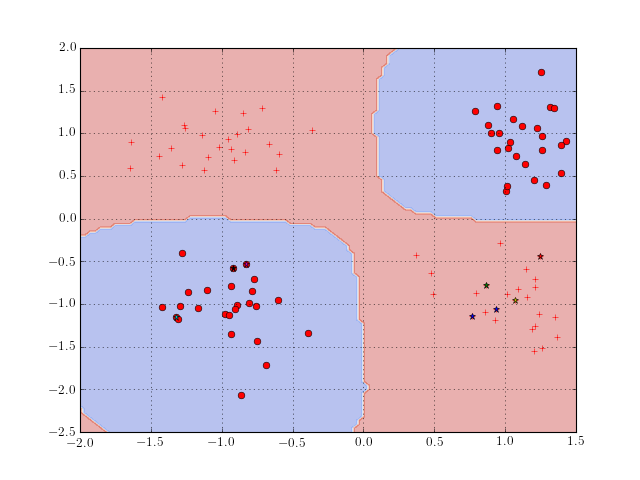

In [29]:
plot.figure()

vis_data(x_tra, y_tra, c='r')
vis_sv(w)

plt1 = vis_decision_boundary(w, 'k--')

plot.show()

In [30]:
x_tra_ = rbf(x_tra, centroids, 1.)
x_tes_ = rbf(x_tes, centroids, 1.)

tra_er = numpy.sum(numpy.abs(svm(x_tra_, w) - y_tra)) / numpy.float(len(y_tra))
tes_er = numpy.sum(numpy.abs(svm(x_tes_, w) - y_tes)) / numpy.float(len(y_tes))

print 'Training error rate {}, Test error rate {}'.format(tra_er, tes_er)

Training error rate 0.0, Test error rate 0.0
